# **Connect to Google Drive:**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import dependencies and verify that files are available:

In [3]:
!pip install nltk
!pip install keras_tuner
!pip install tensorflow==2.15.0
!pip install tf-keras==2.15.0
!pip install transformers==4.37.0
!pip install ipython-autotime
%load_ext autotime

import keras_tuner as kt
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
import nltk
import os
import random as python_random
import json
import argparse
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.initializers import Constant
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import math
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from tensorflow.keras.losses import BinaryCrossentropy


nltk.download('punkt')
nltk.download('stopwords')

# Make reproducible as much as possible
np.random.seed(1234)
tf.random.set_seed(1234)
python_random.seed(1234)

In [4]:
os.listdir('/content/gdrive/MyDrive/data_project/')

['test.tsv',
 'dev.tsv',
 'train.tsv',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt',
 'wiki-news-300d-1M-subword.vec',
 'bad-words.txt']

Pre-processing

In [7]:
def preprocess_texts(text, remove_user, remove_stop, remove_char):
    # Lowercase the text
    text = text.lower()

    # Remove usernames
    if remove_user:
        text = re.sub(r'@user', '', text)
    # Remove unwanted characters or formatting issues using regex
    if remove_char:
        text = re.sub(r"[^a-zA-Z0-9\s.,!?']", ' ', text)
    # Remove stop words
    if remove_stop:
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join(word_tokenize(text))
    return text

Read data

In [8]:
def read_corpus(corpus_file, remove_user=False, remove_stop=False, remove_char=False):
    '''Read in review data set and returns docs and labels'''
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip()
            labels.append(tokens.split()[-1])
            tokens = preprocess_texts(tokens, remove_user, remove_stop, remove_char)
            documents.append(" ".join(tokens.split()[:-1]).strip())
    return documents, labels

def read_embeddings(embeddings_file):
    '''Read in word embeddings from file and save as numpy array'''
    embeddings = {}
    with open(embeddings_file, encoding='utf-8') as f:
        data = f.readlines()

    for line in data:
        tokens = line.strip().split()
        word = tokens[0]
        embedding = np.array(tokens[1:])
        embeddings[word] = embedding
    return embeddings

def get_emb_matrix(voc, emb):
    '''Get embedding matrix given vocab and the embeddings'''
    num_tokens = len(voc) + 2
    word_index = dict(zip(voc, range(len(voc))))
    # Bit hacky, get embedding dimension from the word "the"
    embedding_dim = len(emb["the"])
    # Prepare embedding matrix to the correct size
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = emb.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    # Final matrix with pretrained embeddings that we can feed to embedding layer
    return embedding_matrix

## Change settings

In [9]:
train_file = '/content/gdrive/MyDrive/data_project/train.tsv'
dev_file = '/content/gdrive/MyDrive/data_project/dev.tsv'
test_file = '/content/gdrive/MyDrive/data_project/test.tsv'
embeddings_file = '/content/gdrive/MyDrive/data_project/glove.twitter.27B.25d.txt'
offensive_words = '/content/gdrive/MyDrive/data_project/bad-words.txt'

# LSTM

In [11]:
def preprocess_data(documents, labels, max_len=25):
    '''Tokenize documents, encode labels, and pad sequences'''
    # Text vectorization with a larger vocabulary and custom pre-processing
    vectorizer = TextVectorization(
        max_tokens=20000,
        output_sequence_length=max_len,
        standardize='lower_and_strip_punctuation',
        split='whitespace'
    )

    # Fit the vectorizer on the documents
    vectorizer.adapt(documents)

    # Convert documents to tokenized sequences
    X = vectorizer(documents)

    # Label encoding with handling for unseen labels if needed
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    return X, y, vectorizer, label_encoder


In [12]:
# Load pretrained embeddings
embeddings = read_embeddings(embeddings_file)

In [13]:
# Load training, validation, and test data
train_docs, train_labels = read_corpus(train_file)
dev_docs, dev_labels = read_corpus(dev_file)
test_docs, test_labels = read_corpus(test_file)

# Preprocess the data
max_len = 140
X_train, y_train, vectorizer, label_encoder = preprocess_data(train_docs, train_labels, max_len)
X_val, y_val, _, _ = preprocess_data(dev_docs, dev_labels, max_len)
X_test, y_test, _, _ = preprocess_data(test_docs, test_labels, max_len)

# Prepare embedding matrix
global vocab_size, embedding_dim, embedding_matrix, max_len
vocab = vectorizer.get_vocabulary()
embedding_matrix = get_emb_matrix(vocab, embeddings)
vocab_size = len(vocab) + 2  # Adjusted for padding and OOV tokens
embedding_dim = embedding_matrix.shape[1]

In [14]:
print(train_docs[:5])

['@ user she should ask a few native americans what their take on this is .', '@ user @ user go home you ’ re drunk ! ! ! @ user # maga # trump2020 👊🇺🇸👊 url', 'amazon is investigating chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace . url # amazon # maga # kag # china # tcot', "`` @ user someone should'vetaken '' '' this piece of shit to a volcano . 😂 '' '' ''", '@ user @ user obama wanted liberals & amp ; illegals to move into red states']


In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12240, 140)
(12240,)
(1000, 140)
(1000,)
(860, 140)
(860,)


In [16]:
def build_model(hp):
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.models.Sequential()

    # Embedding layer with pretrained embeddings
    model.add(tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False))

    # LSTM layers
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('units1', min_value=64, max_value=256, step=64), return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('units2', min_value=32, max_value=128, step=32))))

    # Dropout layers
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.4, max_value=0.6, step=0.1)))

    # Output layer for binary classification
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up Keras Tuner with Hyperband
tuner = kt.Hyperband(build_model,
                     objective='binary_crossentropy',
                     max_epochs=20,
                     factor=5,
                     directory='Tuner',
                     project_name='binary_classification_tuning',
                     # Set overwrite to True to clear any existing trials
                     overwrite=False)

# Early stopping callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Run the tuner search on the data
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[stop_early])

Trial 2 Complete [00h 13m 35s]

Best binary_crossentropy So Far: None
Total elapsed time: 00h 39m 14s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |learning_rate
192               |128               |units1
32                |128               |units2
0.5               |0.5               |dropout_rate
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/4
383/383 ━━━━━━━━━━━━━━━━━━━━ 297s 759ms/step - accuracy: 0.6673 - loss: 0.6339 - val_accuracy: 0.6280 - val_loss: 0.6683
Epoch 2/4
383/383 ━━━━━━━━━━━━━━━━━━━━ 291s 759ms/step - accuracy: 0.6982 - loss: 0.5779 - val_accuracy: 0.6230 - val_loss: 0.6806
Epoch 3/4
383/383 ━━━━━━━━━━━━━━━━━━━━ 321s 758ms/step - accuracy: 0.7118 - loss: 0.5607 - val_accuracy: 0.6160 - val_loss: 0.6892
Epoch 4/4
188/383 ━━

In [49]:
# Retrieve the best model after tuning
best_model = tuner.get_best_models(num_models=1)[0]

# print best model hyperparameters
print(best_model.summary())
# learning rate
print(best_model.optimizer.lr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 25)           496000    
                                                                 
 bidirectional (Bidirection  (None, 140, 128)          46080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 641025 (2.45 MB)
Trainable params: 145025 

In [50]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

y_pred_classes = (y_pred > 0.5).astype(int)

27/27 [==============================] - 3s 16ms/step
time: 2.88 s (started: 2024-11-04 19:22:14 +00:00)


In [51]:
# classification report
print(classification_report(y_pred_classes, y_test, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         NOT       0.85      0.72      0.78       734
         OFF       0.15      0.29      0.20       126

    accuracy                           0.66       860
   macro avg       0.50      0.50      0.49       860
weighted avg       0.75      0.66      0.70       860

time: 27.3 ms (started: 2024-11-04 19:22:17 +00:00)


# Baselines & Data Inspection

In [24]:
#Baseline: all 0
y_pred_all_zeros = np.zeros_like(y_test)
print("All 0:")
print(classification_report(y_test, y_pred_all_zeros, target_names=label_encoder.classes_))

#Baseline: all 1
y_pred_all_ones = np.ones_like(y_test)
print("All 1:")
print(classification_report(y_test, y_pred_all_ones, target_names=label_encoder.classes_))

# Embedding coverage
found = sum(1 for word in vocab if word in embeddings)
print(f"Found embeddings for {found} out of {len(vocab)} words.")

# Label distribution
unique_labels, counts = np.unique(y_train, return_counts=True)
print("Label distribution in training set:")
print(dict(zip(label_encoder.inverse_transform(unique_labels), counts)))
print()
unique_labels, counts = np.unique(y_val, return_counts=True)
print("Label distribution in validation set:")
print(dict(zip(label_encoder.inverse_transform(unique_labels), counts)))
print()
unique_labels, counts = np.unique(y_test, return_counts=True)
print("Label distribution in test set:")
print(dict(zip(label_encoder.inverse_transform(unique_labels), counts)))
print()

# Predict based on offensive words
with open(offensive_words, 'r') as f:
    offensive_words_list = f.read().splitlines()


y_pred_offensive = np.zeros_like(y_test)
for i, doc in enumerate(test_docs):
    for word in doc.split():
        if word in offensive_words_list:
            y_pred_offensive[i] = 1

print("Offensive words:")
print(classification_report(y_test, y_pred_offensive, target_names=label_encoder.classes_))

All 0:
              precision    recall  f1-score   support

         NOT       0.72      1.00      0.84       620
         OFF       0.00      0.00      0.00       240

    accuracy                           0.72       860
   macro avg       0.36      0.50      0.42       860
weighted avg       0.52      0.72      0.60       860

All 1:
              precision    recall  f1-score   support

         NOT       0.00      0.00      0.00       620
         OFF       0.28      1.00      0.44       240

    accuracy                           0.28       860
   macro avg       0.14      0.50      0.22       860
weighted avg       0.08      0.28      0.12       860

Found embeddings for 15317 out of 19838 words.
Label distribution in training set:
{'NOT': 8192, 'OFF': 4048}

Label distribution in validation set:
{'NOT': 648, 'OFF': 352}

Label distribution in test set:
{'NOT': 620, 'OFF': 240}



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Offensive words:
              precision    recall  f1-score   support

         NOT       0.83      0.71      0.76       620
         OFF       0.45      0.62      0.52       240

    accuracy                           0.68       860
   macro avg       0.64      0.66      0.64       860
weighted avg       0.72      0.68      0.70       860



# Naive Bayes (BOW)

In [ ]:
# Create a CountVectorizer with optimized features
vectorizer = CountVectorizer(
    max_features=20000,  # Limit to 20,000 features
    # stop_words='english',  # Remove common English stop words
    # lowercase=True,
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# Fit the vectorizer on the training data
X_train_bow = vectorizer.fit_transform(train_docs)

# Transform the validation and test data using the fitted vectorizer
X_val_bow = vectorizer.transform(dev_docs)
X_test_bow = vectorizer.transform(test_docs)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_val = nb_classifier.predict(X_val_bow)

# Predict on the test set
y_pred_test = nb_classifier.predict(X_test_bow)

In [ ]:
print("Validation Set Evaluation:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

Validation Set Evaluation:
              precision    recall  f1-score   support

         NOT       0.74      0.87      0.80       648
         OFF       0.65      0.45      0.53       352

    accuracy                           0.72      1000
   macro avg       0.70      0.66      0.67      1000
weighted avg       0.71      0.72      0.71      1000

Test Set Evaluation:
              precision    recall  f1-score   support

         NOT       0.81      0.91      0.86       620
         OFF       0.67      0.46      0.55       240

    accuracy                           0.79       860
   macro avg       0.74      0.69      0.70       860
weighted avg       0.77      0.79      0.77       860



# SVM

In [ ]:
def preprocess_data(documents, labels, vectorizer=None, label_encoder=None):
    '''Transform documents using TF-IDF and encode labels'''

    if vectorizer is None:
        count_vectorizer = CountVectorizer(
            max_features=20000,  # Limit to 20,000 features
            # stop_words='english',  # Remove common English stop words
            # lowercase=True,
            ngram_range=(1, 2)  # Use unigrams and bigrams
        )
        count_vectorizer.fit(documents)  # Fit only on training
    else:
        count_vectorizer = vectorizer  # Use pre-fitted vectorizer
    X = count_vectorizer.transform(documents)


    # Label encoding
    if label_encoder is None:
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(labels)
    else:
        y = label_encoder.transform(labels) # Use pre-fitted label_encoder

    return X, y, count_vectorizer, label_encoder


# Preprocess the training, validation, and test sets
X_train, y_train, tfidf_vectorizer, label_encoder = preprocess_data(train_docs, train_labels)
X_val, y_val, _, _ = preprocess_data(dev_docs, dev_labels, tfidf_vectorizer, label_encoder)
X_test, y_test, _, _ = preprocess_data(test_docs, test_labels, tfidf_vectorizer, label_encoder)

X_train_np = X_train.toarray()
X_val_np = X_val.toarray()
X_test_np = X_test.toarray()

# Create and train the SVM model
model = LinearSVC(C=0.5, max_iter=10000)  # Adjust C and max_iter as needed
# model = SVC(kernel='rbf', C=1.0, max-iter=5000)
model.fit(X_train_np, y_train)

# Evaluate the model on validation and test sets
y_pred_val = model.predict(X_val_np)
y_pred_test = model.predict(X_test_np)

# Print evaluation reports
print("Validation Set Evaluation:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

Validation Set Evaluation:
              precision    recall  f1-score   support

         NOT       0.77      0.85      0.80       648
         OFF       0.65      0.52      0.58       352

    accuracy                           0.73      1000
   macro avg       0.71      0.68      0.69      1000
weighted avg       0.72      0.73      0.72      1000

Test Set Evaluation:
              precision    recall  f1-score   support

         NOT       0.82      0.86      0.84       620
         OFF       0.59      0.50      0.54       240

    accuracy                           0.76       860
   macro avg       0.70      0.68      0.69       860
weighted avg       0.75      0.76      0.76       860



# Pre-trained language model

In [39]:
learning_rate = 5e-5
batch_size = 16
max_length = 100
epochs = 5

# *** SELECT LANGUAGE MODELS HERE... ***

# language_model = 'bert-base-uncased'
# language_model = 'roberta-base'
language_model = 'microsoft/deberta-v3-base'
# language_model = 'distilbert-base-uncased'
# language_model = 'google/electra-small-generator'
# language_model = 'huawei-noah/TinyBERT_General_4L_312D'
# language_model = 'albert/albert-base-v2'

time: 722 µs (started: 2024-11-04 18:32:12 +00:00)


In [29]:
from sklearn.metrics import classification_report


def test_set_predict(model, tokenizer, X_test, Y_test, ident): # Added tokenizer as an argument
    '''Do predictions and measure accuracy on our own test set (that we split off train)'''
    # Tokenize the test data
    tokens_test = tokenizer(X_test, padding=True, max_length=max_length,
                            truncation=True, return_tensors="np").data
    # Get predictions using the trained model
    Y_pred = model.predict(tokens_test)["logits"] # Predict on tokenized input
    # Finally, convert to numerical labels to get scores with sklearn
    Y_pred = np.argmax(Y_pred, axis=1)
    # If you have gold data, you can calculate accuracy
    Y_test = np.argmax(Y_test, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
    print('Accuracy on own {1} set: {0}'.format(round(accuracy_score(Y_test, Y_pred), 3), ident))
    print('Precision: {0}'.format(round(precision, 3)))
    print('Recall: {0}'.format(round(recall, 3)))
    print('F1: {0}'.format(round(f1, 3)))

    # Confusion matrix
    unique_labels = encoder.classes_

    cm = confusion_matrix(Y_test, Y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
    disp.plot()
    plt.show()

    # classification report
    print(classification_report(Y_test, Y_pred, target_names=unique_labels))

time: 4.11 ms (started: 2024-11-04 18:27:24 +00:00)


Learning rate schedulers

In [23]:
def constant_decay(epoch):
  return learning_rate

def step_decay(epoch):
  initial_lr = learning_rate
  drop = 0.5
  epochs_drop = 2.0
  lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lr

def exp_decay(epoch):
  initial_lr = learning_rate
  k = 0.1
  lr = initial_lr * math.exp(-k*epoch)
  return lr

def polynomial_decay(epoch):
  initial_lr = learning_rate
  power = 1.0
  end_learning_rate = 0.00001
  decay_steps = epochs  # Total number of training epochs
  lr = (initial_lr - end_learning_rate) * (1 - epoch / decay_steps) ** (power) + end_learning_rate
  return lr

time: 1.19 ms (started: 2024-11-04 18:01:47 +00:00)


Load data and train model

In [40]:
# Transform words to indices using a vectorizer
vectorizer = TextVectorization(standardize=None, output_sequence_length=25)

vectorizer.adapt(train_docs)

# Transform string labels to one-hot encodings
encoder = LabelBinarizer()
Y_train_bin = encoder.fit_transform(train_labels)
Y_dev_bin = encoder.fit_transform(dev_labels)
Y_test_bin = encoder.fit_transform(test_labels)

if Y_train_bin.shape[1] == 1:
    Y_train_bin = np.hstack([(1 - Y_train_bin), Y_train_bin])
    Y_dev_bin = np.hstack([(1 - Y_dev_bin), Y_dev_bin])
    Y_test_bin = np.hstack([(1 - Y_test_bin), Y_test_bin])

lm = language_model

tokenizer = AutoTokenizer.from_pretrained(lm)

# Load the pretrained model
model = TFAutoModelForSequenceClassification.from_pretrained(lm, from_pt=True)

tokens_train = tokenizer(train_docs, padding=True, max_length=max_length,
                         truncation=True, return_tensors="np").data
tokens_dev = tokenizer(dev_docs, padding=True, max_length=max_length,
                       truncation=True, return_tensors="np").data

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(polynomial_decay)

# Loss function & optimizer
loss_function = BinaryCrossentropy(from_logits=True)
optim = Adam(learning_rate=learning_rate)

model.compile(loss=loss_function, optimizer=optim, metrics=['accuracy'])
model.fit(tokens_train, Y_train_bin, verbose=1, epochs=epochs,
          batch_size=batch_size, validation_data=(tokens_dev, Y_dev_bin),
          callbacks=[lr_scheduler])

Y_pred = model.predict(tokens_dev)["logits"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_h

Epoch 1/5
765/765 [==============================] - 399s 457ms/step - loss: 0.6548 - accuracy: 0.6650 - val_loss: 0.6491 - val_accuracy: 0.6480 - lr: 0.0050
Epoch 2/5
765/765 [==============================] - 342s 448ms/step - loss: 0.6382 - accuracy: 0.6688 - val_loss: 0.6491 - val_accuracy: 0.6480 - lr: 0.0040
Epoch 3/5
765/765 [==============================] - 344s 449ms/step - loss: 0.6363 - accuracy: 0.6693 - val_loss: 0.6487 - val_accuracy: 0.6480 - lr: 0.0030
Epoch 4/5
765/765 [==============================] - 343s 449ms/step - loss: 0.6354 - accuracy: 0.6693 - val_loss: 0.6585 - val_accuracy: 0.6480 - lr: 0.0020
Epoch 5/5
32/32 [==============================] - 14s 247ms/step
time: 30min 19s (started: 2024-11-04 18:32:17 +00:00)


Dev set

In [36]:
print(Y_train_bin)
print(dev_docs[:5])
print(Y_dev_bin[:5])

[[0 1]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
['@ user @ user you are so beautiful', '@ user he is not a troll he is simply dumb but i ’ m enjoying it i love tweeter for this 🤣🤣🤣🤣🤣🤣🤣', '@ user i understand annie she is stuck in between ! i understand her !', "`` @ user @ user hillary was blaming women not too long ago . better hope the uneducated '' '' do n't show up to vote again . “ it is n't so much that liberals are ignorant . it 's just that they know so many things that are n't so. ” '' '' ''", '@ user @ user i support jahs blessings on his hussle .... he is d bomb']
[[1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
time: 5.59 ms (started: 2024-11-04 18:30:17 +00:00)


32/32 [==============================] - 6s 192ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy on own dev set: 0.648
Precision: 0.42
Recall: 0.648
F1: 0.51


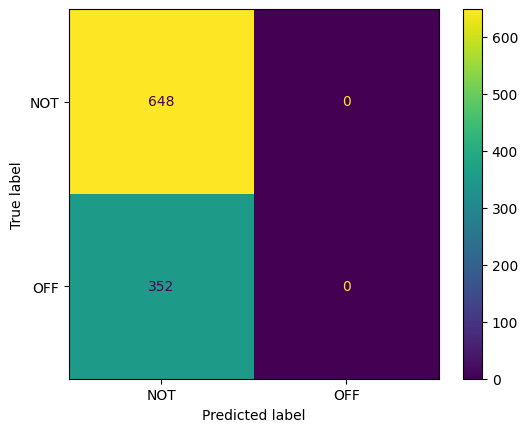

              precision    recall  f1-score   support

         NOT       0.65      1.00      0.79       648
         OFF       0.00      0.00      0.00       352

    accuracy                           0.65      1000
   macro avg       0.32      0.50      0.39      1000
weighted avg       0.42      0.65      0.51      1000

Predicted classes: (array([0]), array([1000]))
time: 10.7 s (started: 2024-11-04 18:28:09 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
Y_pred_binary = np.argmax(Y_pred, axis=1)
test_set_predict(model, tokenizer, dev_docs, Y_dev_bin, "dev")
print("Predicted classes:", np.unique(Y_pred_binary, return_counts=True))

In [42]:
print(Y_pred_binary)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Test set

27/27 [==============================] - 16s 253ms/step
Accuracy on own test set: 0.721
Precision: 0.52
Recall: 0.721
F1: 0.604


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


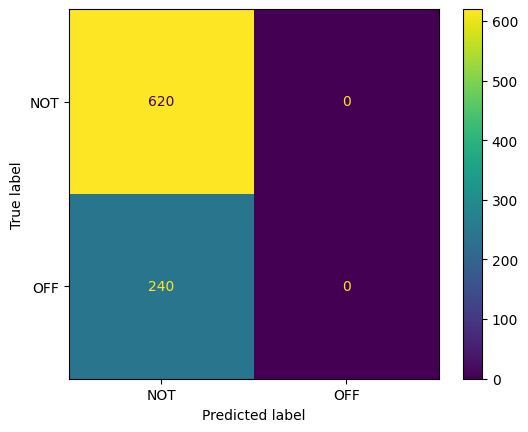

              precision    recall  f1-score   support

         NOT       0.72      1.00      0.84       620
         OFF       0.00      0.00      0.00       240

    accuracy                           0.72       860
   macro avg       0.36      0.50      0.42       860
weighted avg       0.52      0.72      0.60       860

time: 16.3 s (started: 2024-11-04 19:04:10 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
test_set_predict(model, tokenizer, test_docs, Y_test_bin, "test")